In [ ]:
import sys
import numpy as np
import scipy
import scipy.io
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import horovod
import h5py as h5
import os#
import torch
import PINNFramework as pf
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D 
import minterpy as mp

### Define the Simulation Parameters

In [ ]:
ev_x = 0 # n-th eigenvalue of analytical solution
ev_y = 0
#Parameters for
DIM = 2 
DEG = 9
LP=2
POINTKIND = 'gauss_leg'#'leja'
USEDATA = False
#Doamin Bounds
lb = np.array([-1.0, -1.0, 0.0])
ub = np.array([1.0, 1.0, 0])
# Number of Epoch
n_epoch = 2000
#Create 2-D Datast from the analytical solution

In [ ]:
a =  sp.Symbol('a')
b =  sp.Symbol('b')
c =  sp.Symbol('c')
Hna = sp.hermite(ev_x,a)
Hnb = sp.hermite(ev_y,b)
N = (1/((2**ev_x*sp.factorial(ev_x))**(1/2))*(np.pi**(-1/4)))*(1/((2**ev_y*sp.factorial(ev_y))**(1/2))*(np.pi**(-1/4)))
Psi = N*sp.exp(-(a**2+b**2)/2)*Hna*Hnb
lam =sp.simplify((-1/2*(sp.diff(Psi,a,a)+sp.diff(Psi,b,b))+
                        1/2*(a**2+b**2)*Psi)/Psi)
sp.lambdify((a,b),lam)(0,0)

In [ ]:
def set_gen_1d(POLYDEG,n_bdy):
    unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min = [k for k,j in enumerate(unscaled_pts[0]) if abs(j-n_bdy[1][i]) ==
                       min(abs(unscaled_pts[0]-n_bdy[1][i]))]
            scaled_pts.append(unscaled_pts[0][arg_min])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(unscaled_pts[0]*m+b)
            weights.append(unscaled_pts[1]*m)
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights

In [152]:
#from scipy.integrate import quad
#ev = 0
#a =  sp.Symbol('a')
#b =  sp.Symbol('b')
#c =  sp.Symbol('c')
#Hna = sp.hermite(ev,a)
#Hnb = sp.hermite(ev,b)
#Psi = (1/((2**e_l*sp.factorial(ev))**(1/2))*(np.pi**(-1/4))*
# sp.exp(-(a**2+b**2)/2)*Hna*Hnb)
#psi_f = sp.lambdify((a,b),Psi)
#from scipy import integrate
#integrate.dblquad(psi_f, -1, 1, lambda x: 0, lambda x: 1)

#### Dataset Generating fuctions

In [153]:
#Create 2-D Dataset from the analytical solution
def Herm_pol(n):
    p =  sp.Symbol('p')
    Hn = sp.lambdify(p,sp.hermite(n, p))
    return Hn

def eigenvalue (ev_x, ev_y):
    a =  sp.Symbol('a')
    b =  sp.Symbol('b')
    c =  sp.Symbol('c')
    Hna = sp.hermite(ev_x,a)
    Hnb = sp.hermite(ev_y,b)
    N = (1/((2**ev_x*sp.factorial(ev_x))**(1/2))*(np.pi**(-1/4)))*(1/((2**ev_y*sp.factorial(ev_y))**(1/2))*(np.pi**(-1/4)))
    Psi = N*sp.exp(-(a**2+b**2)/2)*Hna*Hnb
    lam =sp.simplify((-1/2*(sp.diff(Psi,a,a)+sp.diff(Psi,b,b))+
                            1/2*(a**2+b**2)*Psi)/Psi)
    return int(sp.lambdify((a,b),lam)(0,0))
lam = eigenvalue(ev_x, ev_y)#2*e_l+1#
def Psi (x,y,t,f):
    x = torch.Tensor(x)
    y= torch.Tensor(y)
    Hx = Herm_pol(ev_x)
    Hy = Herm_pol(ev_y)     
    psi_t = torch.exp(torch.complex(torch.Tensor([0]),torch.Tensor([0])))
    N = 1/((2**ev_x*scipy.math.factorial(ev_x))**(1/2))*(np.pi**(-1/4))*1/((2**ev_y*scipy.math.factorial(ev_y))**(1/2))*(np.pi**(-1/4))
    #1/(1+10*(x**2+y**2))#
    return N*torch.exp(-(x**2+y**2)/2)*Hx(x)*Hy(y)
def set_gen_1d(POLYDEG,n_bdy):
    unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min =[k for k,j in enumerate(unscaled_pts[0]) if abs(j-n_bdy[1][i]) ==
                       min(abs(unscaled_pts[0]-n_bdy[1][i]))] #[k for k,j in enumerate(unscaled_pts[0]) if j-n_bdy[1][i] ==
            #           min(unscaled_pts[0]-n_bdy[1][i])]
            scaled_pts.append([unscaled_pts[0][arg_min[0]]])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(unscaled_pts[0]*m+b)
            weights.append(unscaled_pts[1]*m)
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights

def set_gen_sob(POLYDEG,n_bdy, uns_points, uns_weights):
    #unscaled_pts = np.polynomial.legendre.leggauss(POLYDEG)
    scaled_pts = []
    weights = []
    for i in range(3):
        if (n_bdy[1][i]-n_bdy[0][i])/2 == 0:
            arg_min = [k for k,j in enumerate(uns_points) if j-n_bdy[1][i] == min(uns_points-n_bdy[1][i])]
            scaled_pts.append(uns_points[arg_min])
            weights.append([1])
        else:
            m = (n_bdy[1][i]-n_bdy[0][i])/2
            b = (n_bdy[0][i]+n_bdy[1][i])/2
            scaled_pts.append(uns_points*m+b)
            weights.append(np.multiply(uns_weights,m))
    Grid = np.array([[[[scaled_pts[0][i],scaled_pts[1][j],scaled_pts[2][k]]
                   for i in range(len(scaled_pts[0]))]for j in range(len(scaled_pts[1]))]
                 for k in range(len(scaled_pts[2]))]).reshape(len(scaled_pts[0])
                                                              *len(scaled_pts[1])*
                                                              len(scaled_pts[2]),3)
    Weights = np.array([[[weights[0][i]*weights[1][j]*weights[2][k]
                   for i in range(len(weights[0]))]for j in range(len(weights[1]))]
                 for k in range(len(weights[2]))]).reshape(len(weights[0])
                                                              *len(weights[1])*
                                                              len(weights[2]))
    return Grid, Weights
def MSE_set(n_bdy,  nb, x_dim=1, y_dim=1, nsteps=1, dt=0.1):
    x_0 = np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim)
    y_0 = np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim)
    X, Y = np.meshgrid(x_0, y_0)
    X_0 = X.reshape(-1)
    Y_0 = Y.reshape(-1)
    idx_x = np.random.choice(len(X_0), nb, replace=False)
    x = np.array([X_0[idx_x]]).T
    y = np.array([Y_0[idx_x]]).T
    T = np.zeros(x.shape)
    return np.array(np.concatenate([x,y,T], axis=1))


class BoundaryConditionDataset(Dataset):

    +++def __init__(self, boundary_set) -> object:
        """_bdy, x_dim, y_dim, nsteps, d
        Constructor of the Boundary condition dataset, with x_bdy an array with the
        lower and uper bound in the x direction and respectively y_bdy. Only for square domain.
        """
        self.Bdy_training = boundary_set
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.Bdy_training).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1
class InitialConditionDataset(Dataset):

    def __init__(self,initial_set, norm = 'L2', n_bdy=[], x_dim=1, y_dim=1, nx =1 ):
        """
        Constructor of the boundary condition dataset
        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        if norm =='Mse' or norm== 'Wass':
            x_0 = np.linspace(n_bdy[0][0], n_bdy[1][0], x_dim)
            y_0 = np.linspace(n_bdy[0][1], n_bdy[1][1], y_dim)
            X, Y = np.meshgrid(x_0, y_0)
            X_0 = X.reshape(-1)
            Y_0 = Y.reshape(-1)
            idx_x = np.random.choice(len(X_0), nx, replace=False)
            self.x = np.array([X_0[idx_x]]).T
            self.y = np.array([Y_0[idx_x]]).T
            sol = Psi(self.x, self.y, 0, 1)  # Psi(x,y,t=0,f)
            self.u = sol
            self.t = np.array([np.zeros(len(self.x))]).T
        elif norm == 'Quad' or norm == 'Sobolev_1':
            X = np.array(initial_set[0])
            Y = np.array(initial_set[1])
            #X, Y = np.meshgrid(x_0, y_0)
            self.x = np.array([X.reshape(-1)]).T
            self.y = np.array([Y.reshape(-1)]).T
            sol = Psi(self.x,self.y,0,1)
            self.u = sol
            self.t = np.array([np.zeros(len(self.x))]).T
        else:
            raise ValueError('Norm not defined')
    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self,idx):
        x = np.concatenate([self.x,self.y,self.t],axis=1)
        y = self.u
        return Tensor(x).float(), Tensor(y).float()

class PDEDataset(Dataset):
    def __init__(self, residual_set):
        self.xf = np.array(residual_set).T
    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


#### Definition and creation of the different datasets and losses

In [154]:
def Hk_coeff(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=2, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes
    can_bdy = np.array([[-1, -1, 0], [1, 1, 0]])
    residual_bdy = can_bdy
    un_grid = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[0]
    un_weights = set_gen_sob(deg+1, can_bdy, 
                         np.polynomial.legendre.leggauss(deg+1)[0],
                         np.polynomial.legendre.leggauss(deg+1)[1])[1]#np.polynomial.legendre.leggauss(n+1)[1]
    ord_index = [[ i for i,j in enumerate(un_grid) if j[0] == ord_grid[k][0] and 
                 j[1] == ord_grid[k][1]][0] for k in range(len(ord_grid))]
    ord_sc_weights = un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    W_HK = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        coeff_L_y = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            #custom_grid = mp.Grid(mi,generating_values = grid_r[0][:,0])
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            #alpha = np.divide(1,(1+d_c))
            #sobolev_w = np.divide(lag_poly.coeffs,2)
            coeff_L_x.append(d_c[:,0])
            coeff_L_y.append(d_c[:,1])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        h_w_y = torch.einsum('ab,b->ab',
                     torch.tensor(coeff_L_y),torch.Tensor(ord_sc_weights))
        H_x = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_x), h_w_x)
        H_y = torch.einsum('ab,cb->ac',torch.tensor(coeff_L_y), h_w_y)
        Cx = 1/((deg)**2)
        H_1 = [H_x*Cx, H_y*Cx]
        W_HK.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x))
            HxH_y=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_y),torch.tensor(coeff_L_y))
            HxH = [HxH_x, HxH_y]
            ind_H2 = [[0,0],[0,1],[1,1]]
            H_2 = []
            for i in range(len(ind_H2)):
                H_2.append(torch.einsum('abcd,bd->ac',Cx*HxH[ind_H2[i][0]],H_1[ind_H2[i][1]]))
            W_HK.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = []
                ind_H3 = [[0,0], [0,1],[0,2],[1,0],[1,2]]
                for i in range(len(ind_H3)):
                    H_3.append(torch.einsum('abcd,bd->ac',
                                            Cx*HxH[ind_H3[i][0]],H_2[ind_H3[i][1]]))
                W_HK.append(H_3)
                if k_sob == 4:
                    H_4 = []
                    ind_H4 = [[0,0],[0,1],[0,2],[0,3],[0,4],[1,0],[1,3],[1,4]]
                    for i in range(len(ind_H4)):
                        H_4.append(torch.einsum('abcd,bd->ac',Cx*HxH[ind_H4[i][0]],
                                                H_3[ind_H4[i][1]]))
                    W_HK.append(H_4)
    return ord_sc_grid.T, ord_sc_weights, W_HK
def Hk_coeff_bdy(deg, k_sob):
    mi = mp.multi_index.MultiIndex.from_degree(spatial_dimension=1, poly_degree=deg, lp_degree=np.inf)
    ord_grid =mp.grid.Grid(mi).unisolvent_nodes.T[0]
    un_grid , un_weights = np.polynomial.legendre.leggauss(deg+1)
    ord_index = [[ i for i,j in enumerate(un_grid) if j == ord_grid[k]][0]
                 for k in range(len(ord_grid))]
    Cx = 1/((deg)**2)
    ord_sc_weights = Cx*un_weights[ord_index]
    ord_sc_grid = un_grid[ord_index]
    weights = []
    if k_sob == 1 or k_sob == 2 or k_sob ==3 or k_sob==4:
        coeff_L_x = []
        for i in range(len(mi)):
            alpha = np.zeros(len(mi))
            alpha[i] = 1 
            lag_poly = mp.LagrangePolynomial(alpha, mi)
            derivator_lag_poly = mp.Derivator(lag_poly, mp.LagrangePolynomial)
            d_c = derivator_lag_poly.get_gradient_poly().coeffs
            coeff_L_x.append(d_c[:,0])
        h_w_x = torch.einsum('ab,b->ab',
                 torch.tensor(coeff_L_x),torch.Tensor(ord_sc_weights))
        H_1 = torch.einsum('ab,cb->ac',Cx*torch.tensor(coeff_L_x), h_w_x)
        weights.append(H_1)
        if k_sob == 2 or k_sob ==3 or k_sob==4:
            HxH_x=torch.einsum('ab,cd->abcd',torch.tensor(coeff_L_x),torch.tensor(coeff_L_x)) 
            H_2 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_1)
            weights.append(H_2)
            if  k_sob == 3 or k_sob == 4:
                H_3 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_2)
                weights.append(H_3)
                if k_sob == 4:
                    H_4 = torch.einsum('abcd,bd->ac',Cx*HxH_x,H_3)
                    weights.append(H_4)
    return ord_sc_grid, ord_sc_weights, weights

In [155]:
if __name__ == "__main__":
    # Domain bounds
    #Create Datasets for the different Losses
    def schroedinger1d(x, u):
        global lam
        omega = 1
        pred = u
        u = pred[:, 0]
        #v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        u_t = grad_u[:, 2]
        # v_x = grad_v[:, 0]
        #v_y = grad_v[:, 1]
        #v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        #v_xx = grad_v_x[:, 0]
        #v_yy = grad_v_x[:, 1]
        f_r = -1/2*(u_xx + u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u - lam*u
        #print(torch.mean((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u),torch.std((-1/2*(u_xx - u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u)/u))
        #f_u = -1 * u_t - 0.5 * v_xx - 0.5 * v_yy + omega * 0.5 * (x[:, 0] ** 2) * v + omega * 0.5 * (x[:, 1] ** 2) * v
        # fv is the imaginary part of the schrodinger equation
        #f_v = -1 * v_t + 0.5 * u_xx + 0.5 * u_yy - omega * 0.5 * (x[:, 0] ** 2) * u - omega * 0.5 * (x[:, 1] ** 2) * u
        return f_r#stack([f_u, f_v], 1)  # concatenate real part and imaginary part
    def res_left(x, u):
        omega = 1
        pred = u
        u = pred#pred[:, 0]
        f_left =  lam*u
        return f_left
    def res_right(x, u):
        omega = 1
        pred = u
        u = pred[:, 0]
        #v = pred[:, 1]
        grads = ones(u.shape, device=pred.device)  # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        u_y = grad_u[:, 1]
        #u_t = grad_u[:, 2]
        #v_x = grad_v[:, 0]
        #v_y = grad_v[:, 1]
        #v_t = grad_v[:, 2]
        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        #grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]
        u_xx = grad_u_x[:, 0]
        u_yy = grad_u_x[:, 1]
        #v_xx = grad_v_x[:, 0]
        #v_yy = grad_v_x[:, 1]
        f_right = -1/2*(u_xx + u_yy) + 1/2*(x[:, 0] ** 2 + x[:, 1] ** 2)*u       
        return f_right
    def hom_dir(x):
        P = Psi(x[:,0], x[:,1], x[:,2], 1)
        #P_r = P.real
        #P_im = P.imag
        return P# torch.stack((P_r,P_im),1)
    def Dataset_loss (Norm, bounds , n_points, deg = 1, k_res=0, k_ini =0, k_bdy = 0):
        [lb, ub] = bounds
        residual_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]]
        initial_bdy = [[lb[0], lb[1], lb[2]], [ub[0], ub[1], lb[2]]]
        boundary_bdy = [[[lb[0], lb[1], lb[2]], [lb[0], ub[1], ub[2]]], [[ub[0], lb[1], lb[2]], [ub[0], ub[1], ub[2]]],
                        [[lb[0], lb[1], lb[2]], [ub[0], lb[1], ub[2]]],
                        [[lb[0], ub[1], lb[2]], [ub[0], ub[1], ub[2]]]]
        if Norm == 'Mse' or Norm == 'Wass':
            boundary_set = np.concatenate([MSE_set(boundary_bdy[i], nb= int(n_points/4),
                                                       x_dim=1000, y_dim=1000, nsteps=1, dt=0.1) for i in range(4)], axis=0)
            #boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            residual_set = MSE_set(residual_bdy, nb= n_points, x_dim=1000, y_dim=1000, nsteps=1, dt=0.1).T
            #RS_1d = set_gen_1d(deg, residual_bdy)
            #residual_set = RS_1d[0].T
            initial_set = []
            Datasets = [[boundary_set, residual_set, initial_set],[[0],[0],[0]]]
        elif Norm == 'Quad':
            I_C_1d = set_gen_1d(deg, initial_bdy)
            initial_set = I_C_1d[0].T
            initial_weights = I_C_1d[1]
            boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            boundary_weights = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[1] for i in range(4)], axis=0)
            #boundary_set, boundary_weights, Hb_x, Hb_y,  Hb_xx, Hb_xy, Hb_yy = H1_coeff_bdy(deg)
            RS_1d = set_gen_1d(deg, residual_bdy)
            residual_set = RS_1d[0].T
            residual_weights = RS_1d[1]
            #Hb_x, Hb_y,Hb_xx, Hb_xy, Hb_yy = [[],[],[],[],[]]
            Datasets = [[boundary_set, residual_set, initial_set],[boundary_weights, residual_weights, initial_weights]]
        elif Norm == 'Sobolev_1':
            initial_set, initial_weights, Hkw_ini = Hk_coeff(deg, k_ini)
            residual_set, res_weights , Hkw_res = Hk_coeff(deg, k_res)
            #Create Boundary Set
            boundary_set, boundary_weights, Hkw_bdy = Hk_coeff_bdy(int(deg*deg/4), k_bdy)
            #boundary_set = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[0] for i in range(4)], axis=0)
            #boundary_weights = np.concatenate([set_gen_1d(deg, boundary_bdy[i])[1] for i in range(4)], axis=0)
            Datasets = [[boundary_set, residual_set, initial_set],
                        [[boundary_weights, Hkw_bdy], 
                         [res_weights , Hkw_res],
                         [initial_weights, Hkw_ini]]]
            ### CREATE THE LOSS FUNCTIONS
        else:
            raise(ValueError('Loss not defined'))
        
        ## Crete Loss functions
        #Boundary term
        bc_dataset = BoundaryConditionDataset(Datasets[0][0])
        dirichlet_bc = pf.DirichletBC(func=hom_dir, dataset=bc_dataset,
                                      quad_weights=Datasets[1][0],sob_weights=Datasets[1][0]
                                      , name='Dirichlet BC', 
                                      norm=Norm,reg_param_w = 0.2)
        # Residual Terms
        pde_dataset = PDEDataset(Datasets[0][1])
        pde_loss = pf.PDELoss(pde_dataset, schroedinger1d,
                              func_left = res_left, func_right = res_right,
                              quad_weights=Datasets[1][1],sob_weights=Datasets[1][1], 
                              norm=Norm,reg_param_w = 0.2)
        #print(np.array(Datasets[0][2]).shape)
        #Initial Condition Term
        ic_dataset = InitialConditionDataset(Datasets[0][2], norm=Norm, n_bdy=initial_bdy, x_dim=1000, y_dim=1000, nx=n_points)
        initial_condition = pf.InitialCondition(ic_dataset,  quad_weights=Datasets[1][2], 
                                                norm=Norm, sob_weights=Datasets[1][2])
        #test_loss = tl.My_Loss(ic_dataset,  quad_weights=Datasets[1][2], norm=Norm)
        return [dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], Datasets[1]

In [156]:
folder = r'/home/suarez08/PhD_PINNs/Results_Simulation/22.07/'+str(ev_x)+'_inv2_'+str(n_epoch)
# Call the datasets functions, losses and weights for the training and for the performance measure
[dirichlet_bc_2, pde_loss_2, initial_condition_2], [bc_dataset_2, pde_dataset_2, ic_dataset_2], [boundary_weights_2,
                                                                                     residual_weights_2,
                                                                                     initial_weights_2] = Dataset_loss('Quad', [lb, ub], 1, deg=DEG)
[dirichlet_bc, pde_loss, initial_condition], [bc_dataset, pde_dataset, ic_dataset], [boundary_weights,
                                                                                     residual_weights,
                                                                                     initial_weights] = Dataset_loss('Mse', [lb, ub], len(initial_weights_2), deg=DEG)
[dirichlet_bc_3, pde_loss_3, initial_condition_3], [bc_dataset_3, pde_dataset_3, ic_dataset_3], [boundary_weights_3,
                                                                                     residual_weights_3,
                                                                                     initial_weights_3] = Dataset_loss('Sobolev_1', [lb, ub], len(initial_weights_2), deg=DEG,
                                                                                                                      k_res =2, k_ini = 4)
model_1 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=10, lb=lb, ub=ub, activation=torch.nn.ELU())
#model_2 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=10, lb=lb, ub=ub, activation=torch.nn.ELU())
#model_3 = pf.models.MLP(input_size=3, output_size=1, hidden_size=50, num_hidden=10, lb=lb, ub=ub, activation=torch.nn.ELU())
performance_var = [initial_condition, [dirichlet_bc], pde_loss]
pinn_1 = pf.PINN(model_1, 3, 1, pde_loss,initial_condition, performance_var, [dirichlet_bc], use_gpu=False)
loss_1 = pinn_1.fit(n_epoch, 'Adam', 1e-3,pinn_path=folder+'best_model_Mse_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
#pinn_2 = pf.PINN(model_2, 3, 1, pde_loss_2, initial_condition_2, performance_var, [dirichlet_bc_2] ,use_gpu=False)
#loss_2= pinn_2.fit(n_epoch, 'Adam', 1e-3,pinn_path=folder+
#                'best_model_Quad_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
#pinn_3 = pf.PINN(model_3, 3, 1, pde_loss_3, initial_condition_3, performance_var, [dirichlet_bc] ,use_gpu=False)
#loss_3 = pinn_3.fit(n_epoch, 'Adam', 1e-3,
#                    pinn_path = folder+'best_model_Wass_'+str(DEG)+'_'+str(n_epoch)+'_.pt')

Quad
Mse


/home/suarez08/PhD_PINNs/minterpy/transformation_operators.py:37: UserWarning: building a full transformation matrix from a barycentric transformation. this is inefficient.
  warn('building a full transformation matrix from a barycentric transformation. this is inefficient.')


Sobolev_1
Measure Loss tensor(0.3072, grad_fn=<AddBackward0>)
PINN Loss 0.3072175085544586 Epoch 0 from 2000
Measure Loss tensor(0.1418, grad_fn=<AddBackward0>)
PINN Loss 0.1417870968580246 Epoch 1 from 2000
Measure Loss tensor(0.1047, grad_fn=<AddBackward0>)
PINN Loss 0.10468725115060806 Epoch 2 from 2000
Measure Loss tensor(0.1024, grad_fn=<AddBackward0>)
PINN Loss 0.10236265510320663 Epoch 3 from 2000
Measure Loss tensor(0.1038, grad_fn=<AddBackward0>)
PINN Loss 0.103831946849823 Epoch 4 from 2000
Measure Loss tensor(0.0960, grad_fn=<AddBackward0>)
PINN Loss 0.09602558612823486 Epoch 5 from 2000
Measure Loss tensor(0.0847, grad_fn=<AddBackward0>)
PINN Loss 0.08466836810112 Epoch 6 from 2000
Measure Loss tensor(0.0737, grad_fn=<AddBackward0>)
PINN Loss 0.07369492948055267 Epoch 7 from 2000
Measure Loss tensor(0.0661, grad_fn=<AddBackward0>)
PINN Loss 0.06607147306203842 Epoch 8 from 2000
Measure Loss tensor(0.0613, grad_fn=<AddBackward0>)
PINN Loss 0.06131625920534134 Epoch 9 from 20

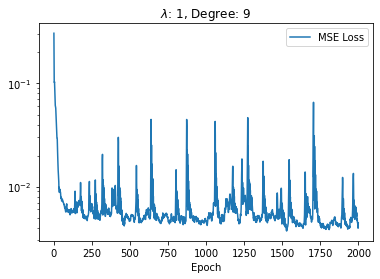

In [157]:
%matplotlib inline
#Produce
#!mkdir /Users/juanesteban/PhD_PINNs/Results_Simulation/27.04/
fig = plt.figure()
 #ax2 = fig.add_subplot(2, 1, 1)
plt.semilogy(loss_1.numpy(), label='MSE Loss')
##plt.semilogy(loss_2.numpy(), label='Quadrature Loss')
#plt.semilogy(loss_3.numpy(), label='Sobolev Loss')
plt.xlabel('Epoch')
#plt.ylabel('H1 Performance')
plt.title('$\lambda$: '+str(lam)+', Degree: '+str(DEG))
plt.legend()
#plt.savefig(folder + 'Sob_H2_H2_loss.png')
plt.show()

display## 

In [87]:
def pred_lam(deg, pinn):
    residual_set, res_weights , Hkw_res = Hk_coeff(deg,0)
    Xs = torch.Tensor(residual_set).T
    Xs.requires_grad = True
    lam = res_right(Xs,pinn(Xs)).dot(torch.Tensor(res_weights))/pinn(Xs).T[0].dot(torch.Tensor(res_weights))
    print(res_right(Xs,pinn(Xs)).dot(torch.Tensor(res_weights)))
    print(pinn(Xs).T[0].dot(torch.Tensor(res_weights)))
    return lam

In [158]:
x_t = np.linspace(lb[0], ub[0],100)
y_t = np.linspace(lb[1], ub[1],100)
t = 0
X_c = torch.tensor([[[i, j, t] for i in x_t] for j in y_t])
X_c1 = X_c.reshape(100*100,3)
X_c1.requires_grad = True
X_m,Y_m = np.meshgrid(x_t,y_t)

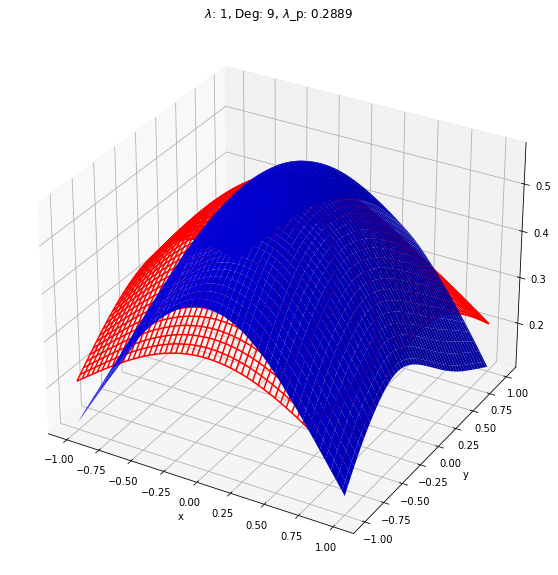

In [159]:
#print(schroedinger1d(X_c, pinn_1(X_c)))
pinn_1.load_model(folder+'best_model_Mse_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_1 = pinn_1(X_c.float())
lam_pred  = np.max(abs(res_right(X_c1,pinn_1(X_c1.float()))-lam*(Psi(X_m,Y_m,1,ev_x).reshape(100*100))).detach().numpy())
lam_pred = "{:.4f}".format(lam_pred)
Li_dist =np.max(abs((PRED_1[:, :, 0])-Psi(X_m,Y_m,1,ev_x)).flatten().detach().numpy())
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')#fig.add_subplot(2, 1, 2, projection='3d')
c1 = ax.plot_surface(X_m, Y_m, PRED_1[:,:,0].detach().numpy(),label='Trained Psi',
                    color='blue')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,0,1),label ='Real Psi',color = 'red')
ax.text(0.5, 0.5, 1, str(Li_dist)+"-"+str(lam_pred), color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
plt.savefig(folder + 'Final_dist_mse.png')
plt.show()


### lam_pred

In [140]:
Li_dist

0.27229795

In [141]:
lam_pred

'1.0603'

In [18]:
pinn_2.load_model(folder+'best_model_Quad_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_2 = pinn_2(X_c.float())
#lam_pred =lam_pred = np.sum((res_right(X_c1,pinn_2(X_c1.float()))-lam*(pinn_2(X_c1.float()))).detach().numpy()**(2))**(1/2)
# lam_pred = pred_lam(30,pinn_2)#torch.mean(torch.div(res_right(X_c1,pinn_2(X_c1.float())),
#                                pinn_2(X_c1.float())[:,0])).detach().numpy()
#lam_pred = "{:.2f}".format(lam_pred)
lam_pred  = np.max(abs(res_right(X_c1,pinn_2(X_c1.float()))-lam*(Psi(X_c1[:,0].float(),X_c1[:,1].float(),1,e_l))).flatten().detach().numpy())
lam_pred = "{:.2f}".format(lam_pred)
Li_dist =np.max(abs((PRED_2[:, :, 0])-Psi(X_m,Y_m,1,e_l)).flatten().detach().numpy())
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_2[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='green')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,0,1),label ='Real Psi',color = 'red')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
ax.text(0.5, 0.5, 1, str(Li_dist)+"-"+str(lam_pred), color='red')
plt.savefig(folder + 'Final_dist_quad.png')
plt.show()


NameError: name 'pinn_2' is not defined

In [19]:
lam_pred

NameError: name 'lam_pred' is not defined

In [20]:
Li_dist

NameError: name 'Li_dist' is not defined

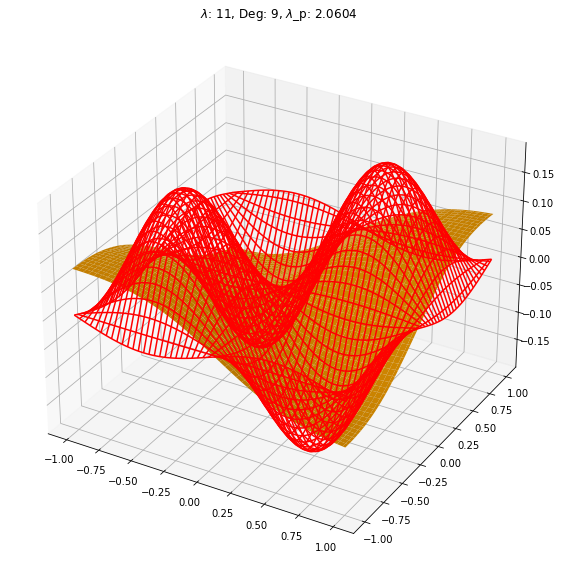

In [115]:
#pinn_3.load_model(folder+'best_model_Wass_'+str(DEG)+'_'+str(n_epoch)+'_.pt')
PRED_3 = model_3(X_c.float())
lam_pred  = np.max(abs(res_right(X_c1,pinn_3(X_c1.float()))-lam*(Psi(X_c1[:,0].float(),X_c1[:,1].float(),1,ev_x))).flatten().detach().numpy())
lam_pred = "{:.4f}".format(lam_pred)
Li_dist = np.max(abs((PRED_3[:, :, 0])-Psi(X_m,Y_m,1,ev_x)).flatten().detach().numpy())
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')#
c2 = ax.plot_surface(X_m, Y_m, PRED_3[:, :, 0].detach().numpy(), label='Trained Psi_wass',
                    color='orange')
c3 = ax.plot_wireframe(X_m, Y_m, Psi(X_m,Y_m,1,ev_x),label ='Real Psi',color = 'red')
ax.text(0.5, 0.5, 1, str(Li_dist)+"-"+str(lam_pred), color='red')
plt.title('$\lambda$: '+str(lam)+', Deg: '+str(DEG)+', $\lambda$_p: '+str(lam_pred))
plt.savefig(folder + 'Final_'+str(DEG)+'_dist_H2_H2.png')
plt.show()

### lam_pred

In [102]:
Li_dist

0.056491923

In [103]:
lam_pred

'0.9200'

In [ ]:
%matplotlib inline

In [ ]:
def Psi (x,y,t,e_l):
    x = torch.Tensor(x)
    y= torch.Tensor(y)
    Hn= Herm_pol(e_l)
    psi_t = torch.exp(torch.complex(torch.Tensor([0]),torch.Tensor([0])))
    return 1/((2**e_l*scipy.math.factorial(e_l))**(1/2))*(np.pi**(-1/4))*torch.exp(-(x**2+y**2)/2)*Hn(x)*Hn(y)
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = #(Psi(X_m,Y_m,1,3)- Psi(X_m,Y_m,1,5)).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_dist_'+str(DEG)+'_dist_H1.png')

In [ ]:
res_right(X_c1,pinn_3(X_c1.float())).reshape(50,50)


In [ ]:
Psi(X_m,Y_m,1,e_l)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_3(X_c1.float())),
                                pinn_3(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')
plt.savefig(folder + 'Eigenvalue_dist_'+str(DEG)+'_dist_H1.png')

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ev_field = torch.div(res_right(X_c1,pinn_2(X_c1.float())),
                                pinn_2(X_c1.float())[:,0]).reshape(50,50).detach().numpy()
ax.plot_surface(X_m, Y_m, ev_field, label='Trained Psi_wass',
                    color='orange')

In [ ]:
folder